In [ ]:
%matplotlib inline
import scipy.io as spio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression

In [ ]:
mat=spio.loadmat('juicesregress.mat', squeeze_me=True)
X=mat['X']
y=mat['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.expand_dims(y_train, axis=1) 
y_test = np.expand_dims(y_test, axis=1) 

In [ ]:
print(X.shape)

(510, 360)


In [ ]:
pls = PLSRegression(n_components=18, scale=True)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test) 

TRAINING SET
RMSEC: 4.094194836632196
R^2 train:  0.9412172363270548


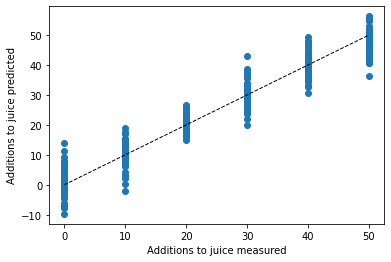

TEST SET
RMSEP: 5.290164954316498
R^2 test:  0.911535430849968


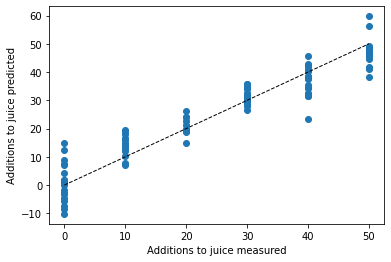

In [ ]:
print('TRAINING SET');
pred_train= pls.predict(X_train)
print('RMSEC:', np.sqrt(mean_squared_error(y_train,pred_train)))
corr,_ = pearsonr(y_train[:,0],pred_train[:,0])
print('R^2 train: ', corr**2)

fig, ax = plt.subplots()
ax.scatter(y_train, pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
ax.set_xlabel('Additions to juice measured')
ax.set_ylabel('Additions to juice predicted')
plt.show()

print('TEST SET');
pred_test= pls.predict(X_test)
print('RMSEP:', np.sqrt(mean_squared_error(y_test,pred_test)))
corr,_ = pearsonr(y_test[:,0],pred_test[:,0])
print('R^2 test: ', corr**2)

fig, ax = plt.subplots()
ax.scatter(y_test, pred_test)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Additions to juice measured')
ax.set_ylabel('Additions to juice predicted')
plt.show()

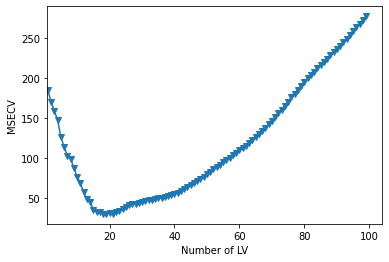

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import model_selection
from sklearn.preprocessing import scale

n = len(X_train)
# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

msecv = []

for i in np.arange(1, 100): 
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    msecv.append(-score)

plt.plot(np.arange(1, 100), np.array(msecv), '-v')
plt.xlabel('Number of LV')
plt.ylabel('MSECV')
plt.xlim(xmin=0.8)
plt.show()


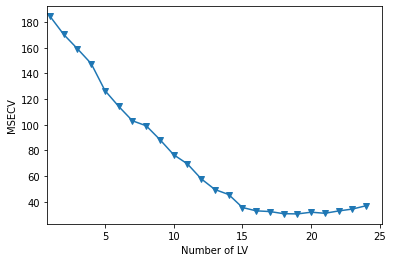

In [ ]:
msecv = []
for i in np.arange(1, 25): 
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    msecv.append(-score)

plt.plot(np.arange(1, 25), np.array(msecv), '-v')
plt.xlabel('Number of LV')
plt.ylabel('MSECV')
plt.xlim(xmin=0.8)
plt.show()

Komentarz:

Na podstawie wykresu można stwierdzić że optymalna liczba LV oscyluje w okolicach 17-19. Uzyskane wyniki sugerują małe przeuczenie modelu PLS. Sprawdzono LV tylko od 0 do 100 ze względu na oszczędność czasu i widoczne zwiększanie się MSECV.

**CNN**

In [ ]:
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, Conv1D, LSTM
from tensorflow.python.keras import Sequential
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [ ]:
mat=spio.loadmat('juicesregress.mat', squeeze_me=True)
X=mat['X']
y=mat['y']

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = np.expand_dims(X_train, axis=2) 
X_test = np.expand_dims(X_test, axis=2)
y_train = np.expand_dims(y_train, axis=1) 
y_test = np.expand_dims(y_test, axis=1) 

In [ ]:
model=Sequential()
model.add(Conv1D(16, kernel_size=3, activation='relu', input_shape=(360,1)))
model.add(Dropout(0.6))
model.add(Conv1D(32, 3, activation='relu'))
model.add(Dropout(0.6))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.8))
model.add(Dense(40, activation='linear'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 358, 16)           64        
_________________________________________________________________
dropout_21 (Dropout)         (None, 358, 16)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 356, 32)           1568      
_________________________________________________________________
dropout_22 (Dropout)         (None, 356, 32)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 354, 64)           6208      
_________________________________________________________________
flatten_7 (Flatten)          (None, 22656)             0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 22656)            

In [ ]:
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mae', 'mse', 'acc'])

In [ ]:
mymodel=model.fit(X_train,
          y_train,
          batch_size=10,
          epochs=200, 
          verbose=0,
          validation_data=(X_test, y_test),
)

History:  dict_keys(['loss', 'mae', 'mse', 'acc', 'val_loss', 'val_mae', 'val_mse', 'val_acc'])


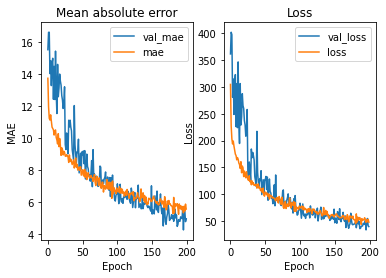

TRAINING SET
RMSEC: 5.100769
R^2 train:  0.9074483829022065


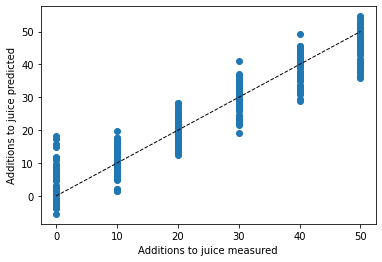

TEST SET
RMSEP: 6.2823544
R^2 test:  0.8914086093996206


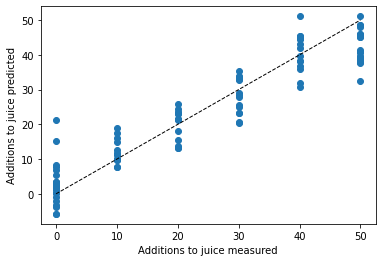

In [ ]:
print('History: ', mymodel.history.keys())

plt.figure()
plt.subplot(1,2,1)
plt.plot(mymodel.history['val_mae'])
plt.plot(mymodel.history['mae'])
plt.title('Mean absolute error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['val_mae', 'mae'], loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(mymodel.history['val_loss'])
plt.plot(mymodel.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'loss'], loc = 'upper right')
plt.show()

print('TRAINING SET');
pred_train= model.predict(X_train)
print('RMSEC:', np.sqrt(mean_squared_error(y_train,pred_train)))
corr,_ = pearsonr(y_train[:,0],pred_train[:,0])
print('R^2 train: ', corr**2)

fig, ax = plt.subplots()
ax.scatter(y_train, pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
ax.set_xlabel('Additions to juice measured')
ax.set_ylabel('Additions to juice predicted')
plt.show()

print('TEST SET');
pred_test= model.predict(X_test)
print('RMSEP:', np.sqrt(mean_squared_error(y_test,pred_test)))
corr,_ = pearsonr(y_test[:,0],pred_test[:,0])
print('R^2 test: ', corr**2)

fig, ax = plt.subplots()
ax.scatter(y_test, pred_test)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Additions to juice measured')
ax.set_ylabel('Additions to juice predicted')
plt.show()

Komentarz:

Modele bardzo łatwo przetrenować oraz ciężko dostosować warunki.